In [36]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk
import pandas as pd


In [43]:
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [37]:
# Set parameters
IMAGE_SIZE = (256, 256)


In [38]:
mask_files = glob('./brainMRI/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]

In [39]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1
1,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1
2,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,0
3,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,0
4,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1


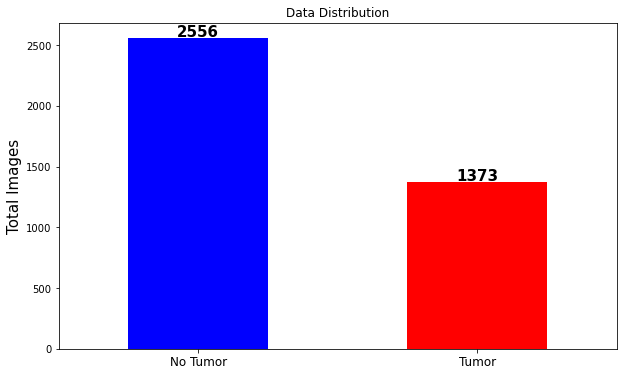

In [40]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

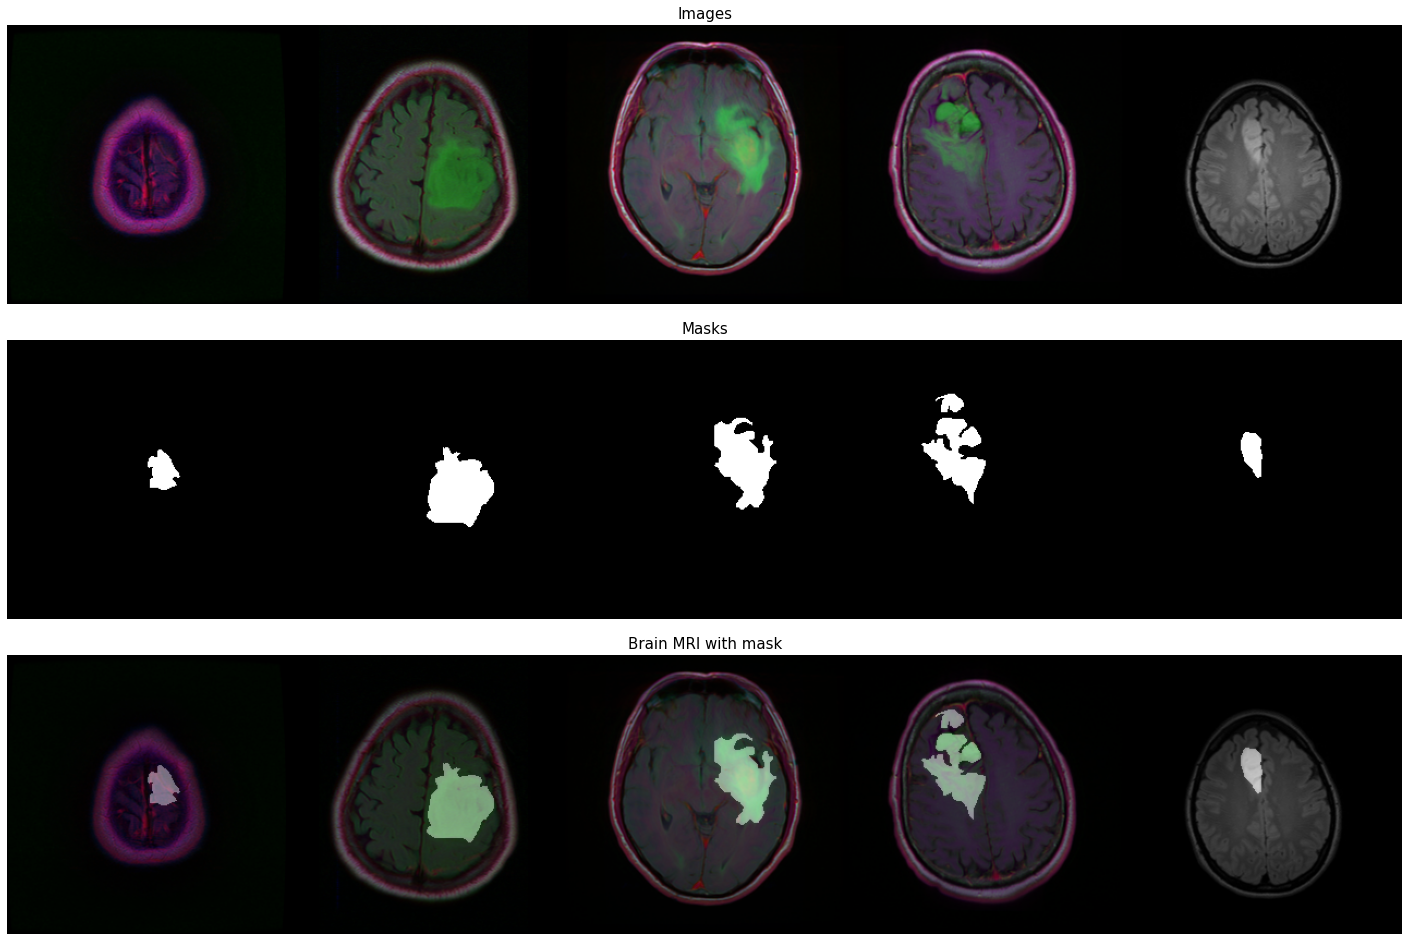

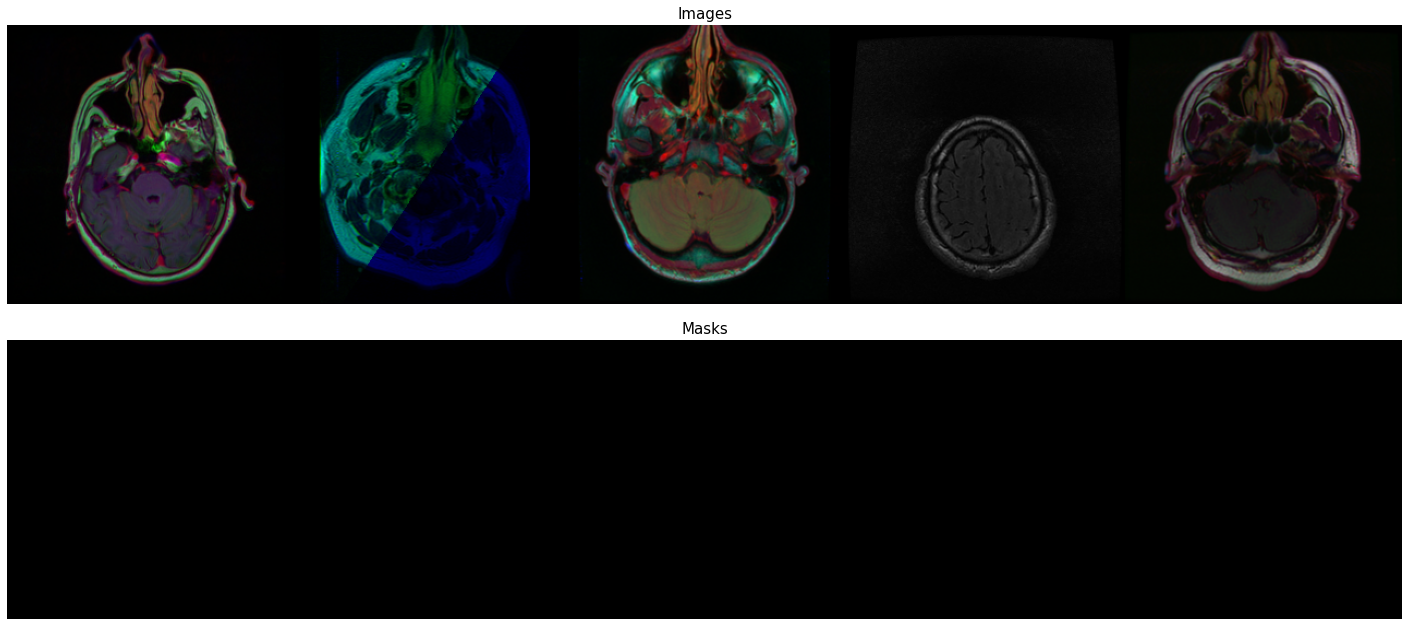

In [41]:
df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

In [42]:


from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)



(2838, 3)
(501, 3)
(590, 3)


In [57]:
df_train.values[3][2]

'0'